In [3]:
import numpy as np
import pandas as pd
import os.path
import json

import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score

%matplotlib inline



Reading NYC Restaurant Inspection data into DataFrame to grab restaurant title/address to generate appropriate yelp urls for futures scraping

In [4]:
nyccsv = '/Users/allandong/ds/metis/metisgh/Project-two-Luther/DOHMH_New_York_City_Restaurant_Inspection_Results.csv'

df = pd.read_csv(nyccsv)

cols = ['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE', 'CUISINE_DESC',
           'INSPECTION_DATE', 'ACTION', 'VIOLATION_CODE', 'VIOLATION_DESC', 'CRITICAL_FLAG',
           'SCORE', 'GRADE', 'GRADE_DATE', 'RECORD_DATE', 'INSPECTION_TYPE']
df.columns = cols


df['ADDRESS'] = df.BUILDING + " " + df.STREET + " " + df.BORO

def yelp_url_gen(row):
    # yelp_url_gen:
    #     Yelp search urls are formulatic based upon "Find" and "Location" inserted values -
    #   so, I can generate what the urls would be if I serached by restaurant title and
    #   restaurant address

    title1 = row['DBA'].replace(" ", "+")
    address1 = row['ADDRESS'].replace(" ", "+")
    return "https://www.yelp.com/search?find_desc={title1}&find_loc={address1}".format(title1=title1, address1=address1)

df_clean = df.dropna(axis=0, how='any')
df_clean['URL'] = df_clean.apply(yelp_url_gen, axis = 1)

/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Export df_clean to csv for scrapy

In [5]:
path = '/Users/allandong/ds/metis/metisgh/Project-two-Luther/df_clean.csv'
df_clean.to_csv(path)

urllist=list(df_clean['URL'])

In [153]:
df_clean.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE_DESC', 'INSPECTION_DATE', 'ACTION', 'VIOLATION_CODE',
       'VIOLATION_DESC', 'CRITICAL_FLAG', 'SCORE', 'GRADE', 'GRADE_DATE',
       'RECORD_DATE', 'INSPECTION_TYPE', 'ADDRESS', 'URL'],
      dtype='object')

In [24]:
df_clean[df_clean['SCORE'] == 131]

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESC,INSPECTION_DATE,ACTION,VIOLATION_CODE,VIOLATION_DESC,CRITICAL_FLAG,SCORE,GRADE,GRADE_DATE,RECORD_DATE,INSPECTION_TYPE,ADDRESS,URL
34196,40372466,MURALS ON 54/RANDOLPHS'S,MANHATTAN,65,WEST 54 STREET,10019.0,2122477000,American,03/28/2014,Violations were cited in the following area(s).,06I,Food not labeled in accordance with HACCP plan.,Critical,131.0,C,03/28/2014,07/09/2017,Cycle Inspection / Re-inspection,65 WEST 54 STREET MANHATTAN,https://www.yelp.com/search?find_desc=MURALS+O...
77096,40372466,MURALS ON 54/RANDOLPHS'S,MANHATTAN,65,WEST 54 STREET,10019.0,2122477000,American,03/28/2014,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,131.0,C,03/28/2014,07/09/2017,Cycle Inspection / Re-inspection,65 WEST 54 STREET MANHATTAN,https://www.yelp.com/search?find_desc=MURALS+O...
205096,40372466,MURALS ON 54/RANDOLPHS'S,MANHATTAN,65,WEST 54 STREET,10019.0,2122477000,American,03/28/2014,Violations were cited in the following area(s).,06G,HACCP plan not approved or approved HACCP plan...,Critical,131.0,C,03/28/2014,07/09/2017,Cycle Inspection / Re-inspection,65 WEST 54 STREET MANHATTAN,https://www.yelp.com/search?find_desc=MURALS+O...
250571,40372466,MURALS ON 54/RANDOLPHS'S,MANHATTAN,65,WEST 54 STREET,10019.0,2122477000,American,03/28/2014,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,131.0,C,03/28/2014,07/09/2017,Cycle Inspection / Re-inspection,65 WEST 54 STREET MANHATTAN,https://www.yelp.com/search?find_desc=MURALS+O...
259060,40372466,MURALS ON 54/RANDOLPHS'S,MANHATTAN,65,WEST 54 STREET,10019.0,2122477000,American,03/28/2014,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Critical,131.0,C,03/28/2014,07/09/2017,Cycle Inspection / Re-inspection,65 WEST 54 STREET MANHATTAN,https://www.yelp.com/search?find_desc=MURALS+O...
333180,40372466,MURALS ON 54/RANDOLPHS'S,MANHATTAN,65,WEST 54 STREET,10019.0,2122477000,American,03/28/2014,Violations were cited in the following area(s).,06A,Personal cleanliness inadequate. Outer garment...,Critical,131.0,C,03/28/2014,07/09/2017,Cycle Inspection / Re-inspection,65 WEST 54 STREET MANHATTAN,https://www.yelp.com/search?find_desc=MURALS+O...
342230,40372466,MURALS ON 54/RANDOLPHS'S,MANHATTAN,65,WEST 54 STREET,10019.0,2122477000,American,03/28/2014,Violations were cited in the following area(s).,06H,Records and logs not maintained to demonstrate...,Critical,131.0,C,03/28/2014,07/09/2017,Cycle Inspection / Re-inspection,65 WEST 54 STREET MANHATTAN,https://www.yelp.com/search?find_desc=MURALS+O...


In [25]:
df_clean[df_clean['SCORE'] == 94].head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESC,INSPECTION_DATE,ACTION,VIOLATION_CODE,VIOLATION_DESC,CRITICAL_FLAG,SCORE,GRADE,GRADE_DATE,RECORD_DATE,INSPECTION_TYPE,ADDRESS,URL
65915,50060082,EUROCREPE,QUEENS,NKA,JFK INTERNATIONAL AIRPORT,11430.0,7186561500,CafÃ©/Coffee/Tea,06/08/2017,Violations were cited in the following area(s).,03E,Potable water supply inadequate. Water or ice ...,Critical,94.0,Z,06/08/2017,07/09/2017,Pre-permit (Operational) / Re-inspection,NKA JFK INTERNATIONAL AIRPORT QUEENS,https://www.yelp.com/search?find_desc=EUROCREP...
72704,50060082,EUROCREPE,QUEENS,NKA,JFK INTERNATIONAL AIRPORT,11430.0,7186561500,CafÃ©/Coffee/Tea,06/08/2017,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,94.0,Z,06/08/2017,07/09/2017,Pre-permit (Operational) / Re-inspection,NKA JFK INTERNATIONAL AIRPORT QUEENS,https://www.yelp.com/search?find_desc=EUROCREP...
176306,50060082,EUROCREPE,QUEENS,NKA,JFK INTERNATIONAL AIRPORT,11430.0,7186561500,CafÃ©/Coffee/Tea,06/08/2017,Violations were cited in the following area(s).,05H,"No facilities available to wash, rinse and san...",Critical,94.0,Z,06/08/2017,07/09/2017,Pre-permit (Operational) / Re-inspection,NKA JFK INTERNATIONAL AIRPORT QUEENS,https://www.yelp.com/search?find_desc=EUROCREP...
188019,50060082,EUROCREPE,QUEENS,NKA,JFK INTERNATIONAL AIRPORT,11430.0,7186561500,CafÃ©/Coffee/Tea,06/08/2017,Violations were cited in the following area(s).,06E,"Sanitized equipment or utensil, including in-u...",Critical,94.0,Z,06/08/2017,07/09/2017,Pre-permit (Operational) / Re-inspection,NKA JFK INTERNATIONAL AIRPORT QUEENS,https://www.yelp.com/search?find_desc=EUROCREP...
309584,50060082,EUROCREPE,QUEENS,NKA,JFK INTERNATIONAL AIRPORT,11430.0,7186561500,CafÃ©/Coffee/Tea,06/08/2017,Violations were cited in the following area(s).,05D,Hand washing facility not provided in or near ...,Critical,94.0,Z,06/08/2017,07/09/2017,Pre-permit (Operational) / Re-inspection,NKA JFK INTERNATIONAL AIRPORT QUEENS,https://www.yelp.com/search?find_desc=EUROCREP...


In [26]:
df_clean[df_clean['SCORE'] == 86].head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESC,INSPECTION_DATE,ACTION,VIOLATION_CODE,VIOLATION_DESC,CRITICAL_FLAG,SCORE,GRADE,GRADE_DATE,RECORD_DATE,INSPECTION_TYPE,ADDRESS,URL
19434,50000040,D & Y RESTAURANT,BROOKLYN,5616,7TH AVE,11220.0,7184928808,Chinese,11/24/2014,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,86.0,C,11/24/2014,07/09/2017,Cycle Inspection / Re-inspection,5616 7TH AVE BROOKLYN,https://www.yelp.com/search?find_desc=D+&+Y+RE...
28884,50000040,D & Y RESTAURANT,BROOKLYN,5616,7TH AVE,11220.0,7184928808,Chinese,11/24/2014,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,86.0,C,11/24/2014,07/09/2017,Cycle Inspection / Re-inspection,5616 7TH AVE BROOKLYN,https://www.yelp.com/search?find_desc=D+&+Y+RE...
59082,50000040,D & Y RESTAURANT,BROOKLYN,5616,7TH AVE,11220.0,7184928808,Chinese,11/24/2014,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Critical,86.0,C,11/24/2014,07/09/2017,Cycle Inspection / Re-inspection,5616 7TH AVE BROOKLYN,https://www.yelp.com/search?find_desc=D+&+Y+RE...
239194,50000040,D & Y RESTAURANT,BROOKLYN,5616,7TH AVE,11220.0,7184928808,Chinese,11/24/2014,Violations were cited in the following area(s).,05D,Hand washing facility not provided in or near ...,Critical,86.0,C,11/24/2014,07/09/2017,Cycle Inspection / Re-inspection,5616 7TH AVE BROOKLYN,https://www.yelp.com/search?find_desc=D+&+Y+RE...
254098,50000040,D & Y RESTAURANT,BROOKLYN,5616,7TH AVE,11220.0,7184928808,Chinese,11/24/2014,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,86.0,C,11/24/2014,07/09/2017,Cycle Inspection / Re-inspection,5616 7TH AVE BROOKLYN,https://www.yelp.com/search?find_desc=D+&+Y+RE...


In [27]:
df_clean[df_clean['SCORE'] == 83]

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESC,INSPECTION_DATE,ACTION,VIOLATION_CODE,VIOLATION_DESC,CRITICAL_FLAG,SCORE,GRADE,GRADE_DATE,RECORD_DATE,INSPECTION_TYPE,ADDRESS,URL
104578,41678381,MOTI MAHAL DELUX,MANHATTAN,1149,1 AVENUE,10065.0,2123713535,Indian,08/17/2016,Violations were cited in the following area(s).,05F,Insufficient or no refrigerated or hot holding...,Critical,83.0,C,08/17/2016,07/09/2017,Cycle Inspection / Re-inspection,1149 1 AVENUE MANHATTAN,https://www.yelp.com/search?find_desc=MOTI+MAH...
119275,41678381,MOTI MAHAL DELUX,MANHATTAN,1149,1 AVENUE,10065.0,2123713535,Indian,08/17/2016,Violations were cited in the following area(s).,06F,Wiping cloths soiled or not stored in sanitizi...,Critical,83.0,C,08/17/2016,07/09/2017,Cycle Inspection / Re-inspection,1149 1 AVENUE MANHATTAN,https://www.yelp.com/search?find_desc=MOTI+MAH...
147106,41678381,MOTI MAHAL DELUX,MANHATTAN,1149,1 AVENUE,10065.0,2123713535,Indian,08/17/2016,Violations were cited in the following area(s).,08C,Pesticide use not in accordance with label or ...,Not Critical,83.0,C,08/17/2016,07/09/2017,Cycle Inspection / Re-inspection,1149 1 AVENUE MANHATTAN,https://www.yelp.com/search?find_desc=MOTI+MAH...
233915,41678381,MOTI MAHAL DELUX,MANHATTAN,1149,1 AVENUE,10065.0,2123713535,Indian,08/17/2016,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Critical,83.0,C,08/17/2016,07/09/2017,Cycle Inspection / Re-inspection,1149 1 AVENUE MANHATTAN,https://www.yelp.com/search?find_desc=MOTI+MAH...
237852,41678381,MOTI MAHAL DELUX,MANHATTAN,1149,1 AVENUE,10065.0,2123713535,Indian,08/17/2016,Violations were cited in the following area(s).,04E,"Toxic chemical improperly labeled, stored or u...",Critical,83.0,C,08/17/2016,07/09/2017,Cycle Inspection / Re-inspection,1149 1 AVENUE MANHATTAN,https://www.yelp.com/search?find_desc=MOTI+MAH...
271475,41678381,MOTI MAHAL DELUX,MANHATTAN,1149,1 AVENUE,10065.0,2123713535,Indian,08/17/2016,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,83.0,C,08/17/2016,07/09/2017,Cycle Inspection / Re-inspection,1149 1 AVENUE MANHATTAN,https://www.yelp.com/search?find_desc=MOTI+MAH...
371629,41678381,MOTI MAHAL DELUX,MANHATTAN,1149,1 AVENUE,10065.0,2123713535,Indian,08/17/2016,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,83.0,C,08/17/2016,07/09/2017,Cycle Inspection / Re-inspection,1149 1 AVENUE MANHATTAN,https://www.yelp.com/search?find_desc=MOTI+MAH...
373256,41678381,MOTI MAHAL DELUX,MANHATTAN,1149,1 AVENUE,10065.0,2123713535,Indian,08/17/2016,Violations were cited in the following area(s).,02H,Food not cooled by an approved method whereby ...,Critical,83.0,C,08/17/2016,07/09/2017,Cycle Inspection / Re-inspection,1149 1 AVENUE MANHATTAN,https://www.yelp.com/search?find_desc=MOTI+MAH...
377157,41678381,MOTI MAHAL DELUX,MANHATTAN,1149,1 AVENUE,10065.0,2123713535,Indian,08/17/2016,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,83.0,C,08/17/2016,07/09/2017,Cycle Inspection / Re-inspection,1149 1 AVENUE MANHATTAN,https://www.yelp.com/search?find_desc=MOTI+MAH...
392024,41678381,MOTI MAHAL DELUX,MANHATTAN,1149,1 AVENUE,10065.0,2123713535,Indian,08/17/2016,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Critical,83.0,C,08/17/2016,07/09/2017,Cycle Inspection / Re-inspection,1149 1 AVENUE MANHATTAN,https://www.yelp.com/search?find_desc=MOTI+MAH...


In [28]:
df_clean[df_clean['SCORE'] == 82]

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESC,INSPECTION_DATE,ACTION,VIOLATION_CODE,VIOLATION_DESC,CRITICAL_FLAG,SCORE,GRADE,GRADE_DATE,RECORD_DATE,INSPECTION_TYPE,ADDRESS,URL
15520,50014192,LA POTENCIA RESTAURANT,BRONX,1898,JEROME AVE,10453.0,9178013200,"Latin (Cuban, Dominican, Puerto Rican, South &...",10/07/2014,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,82.0,C,10/07/2014,07/09/2017,Pre-permit (Operational) / Re-inspection,1898 JEROME AVE BRONX,https://www.yelp.com/search?find_desc=LA+POTEN...
80719,50014192,LA POTENCIA RESTAURANT,BRONX,1898,JEROME AVE,10453.0,9178013200,"Latin (Cuban, Dominican, Puerto Rican, South &...",10/07/2014,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Critical,82.0,C,10/07/2014,07/09/2017,Pre-permit (Operational) / Re-inspection,1898 JEROME AVE BRONX,https://www.yelp.com/search?find_desc=LA+POTEN...
113461,50014192,LA POTENCIA RESTAURANT,BRONX,1898,JEROME AVE,10453.0,9178013200,"Latin (Cuban, Dominican, Puerto Rican, South &...",10/07/2014,Violations were cited in the following area(s).,06B,"Tobacco use, eating, or drinking from open con...",Critical,82.0,C,10/07/2014,07/09/2017,Pre-permit (Operational) / Re-inspection,1898 JEROME AVE BRONX,https://www.yelp.com/search?find_desc=LA+POTEN...
136650,50014192,LA POTENCIA RESTAURANT,BRONX,1898,JEROME AVE,10453.0,9178013200,"Latin (Cuban, Dominican, Puerto Rican, South &...",10/07/2014,Violations were cited in the following area(s).,04J,Appropriately scaled metal stem-type thermomet...,Critical,82.0,C,10/07/2014,07/09/2017,Pre-permit (Operational) / Re-inspection,1898 JEROME AVE BRONX,https://www.yelp.com/search?find_desc=LA+POTEN...
348136,50014192,LA POTENCIA RESTAURANT,BRONX,1898,JEROME AVE,10453.0,9178013200,"Latin (Cuban, Dominican, Puerto Rican, South &...",10/07/2014,Violations were cited in the following area(s).,05D,Hand washing facility not provided in or near ...,Critical,82.0,C,10/07/2014,07/09/2017,Pre-permit (Operational) / Re-inspection,1898 JEROME AVE BRONX,https://www.yelp.com/search?find_desc=LA+POTEN...
372646,50014192,LA POTENCIA RESTAURANT,BRONX,1898,JEROME AVE,10453.0,9178013200,"Latin (Cuban, Dominican, Puerto Rican, South &...",10/07/2014,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,Not Critical,82.0,C,10/07/2014,07/09/2017,Pre-permit (Operational) / Re-inspection,1898 JEROME AVE BRONX,https://www.yelp.com/search?find_desc=LA+POTEN...
379454,50014192,LA POTENCIA RESTAURANT,BRONX,1898,JEROME AVE,10453.0,9178013200,"Latin (Cuban, Dominican, Puerto Rican, South &...",10/07/2014,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,82.0,C,10/07/2014,07/09/2017,Pre-permit (Operational) / Re-inspection,1898 JEROME AVE BRONX,https://www.yelp.com/search?find_desc=LA+POTEN...
397373,50014192,LA POTENCIA RESTAURANT,BRONX,1898,JEROME AVE,10453.0,9178013200,"Latin (Cuban, Dominican, Puerto Rican, South &...",10/07/2014,Violations were cited in the following area(s).,04A,Food Protection Certificate not held by superv...,Critical,82.0,C,10/07/2014,07/09/2017,Pre-permit (Operational) / Re-inspection,1898 JEROME AVE BRONX,https://www.yelp.com/search?find_desc=LA+POTEN...


In [29]:
df_clean[df_clean['SCORE'] == 73]

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESC,INSPECTION_DATE,ACTION,VIOLATION_CODE,VIOLATION_DESC,CRITICAL_FLAG,SCORE,GRADE,GRADE_DATE,RECORD_DATE,INSPECTION_TYPE,ADDRESS,URL
4570,41163308,LOS POLLITOS III,BROOKLYN,499,MYRTLE AVENUE,11205.0,7186366125,Mexican,05/08/2014,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,73.0,C,05/08/2014,07/09/2017,Cycle Inspection / Re-inspection,499 MYRTLE AVENUE BROOKLYN,https://www.yelp.com/search?find_desc=LOS+POLL...
17951,50001637,YOLANDA RESTAURANT,BROOKLYN,188,JAMAICA AVE,11207.0,7182771737,Spanish,07/31/2015,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Critical,73.0,C,07/31/2015,07/09/2017,Cycle Inspection / Re-inspection,188 JAMAICA AVE BROOKLYN,https://www.yelp.com/search?find_desc=YOLANDA+...
21091,41163308,LOS POLLITOS III,BROOKLYN,499,MYRTLE AVENUE,11205.0,7186366125,Mexican,05/08/2014,Violations were cited in the following area(s).,04H,"Raw, cooked or prepared food is adulterated, c...",Critical,73.0,C,05/08/2014,07/09/2017,Cycle Inspection / Re-inspection,499 MYRTLE AVENUE BROOKLYN,https://www.yelp.com/search?find_desc=LOS+POLL...
23245,50001637,YOLANDA RESTAURANT,BROOKLYN,188,JAMAICA AVE,11207.0,7182771737,Spanish,07/31/2015,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,Not Critical,73.0,C,07/31/2015,07/09/2017,Cycle Inspection / Re-inspection,188 JAMAICA AVE BROOKLYN,https://www.yelp.com/search?find_desc=YOLANDA+...
53706,41163308,LOS POLLITOS III,BROOKLYN,499,MYRTLE AVENUE,11205.0,7186366125,Mexican,05/08/2014,Violations were cited in the following area(s).,03B,"Shellfish not from approved source, improperly...",Critical,73.0,C,05/08/2014,07/09/2017,Cycle Inspection / Re-inspection,499 MYRTLE AVENUE BROOKLYN,https://www.yelp.com/search?find_desc=LOS+POLL...
73959,50001637,YOLANDA RESTAURANT,BROOKLYN,188,JAMAICA AVE,11207.0,7182771737,Spanish,07/31/2015,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,73.0,C,07/31/2015,07/09/2017,Cycle Inspection / Re-inspection,188 JAMAICA AVE BROOKLYN,https://www.yelp.com/search?find_desc=YOLANDA+...
91154,50018258,SABOR DE CUBA,QUEENS,3703,31ST AVE,11103.0,7187771693,"Latin (Cuban, Dominican, Puerto Rican, South &...",04/22/2015,Violations were cited in the following area(s).,05D,Hand washing facility not provided in or near ...,Critical,73.0,C,04/22/2015,07/09/2017,Pre-permit (Operational) / Re-inspection,3703 31ST AVE QUEENS,https://www.yelp.com/search?find_desc=SABOR+DE...
99448,41163308,LOS POLLITOS III,BROOKLYN,499,MYRTLE AVENUE,11205.0,7186366125,Mexican,05/08/2014,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,Not Critical,73.0,C,05/08/2014,07/09/2017,Cycle Inspection / Re-inspection,499 MYRTLE AVENUE BROOKLYN,https://www.yelp.com/search?find_desc=LOS+POLL...
112098,41163308,LOS POLLITOS III,BROOKLYN,499,MYRTLE AVENUE,11205.0,7186366125,Mexican,05/08/2014,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Critical,73.0,C,05/08/2014,07/09/2017,Cycle Inspection / Re-inspection,499 MYRTLE AVENUE BROOKLYN,https://www.yelp.com/search?find_desc=LOS+POLL...
155235,50001637,YOLANDA RESTAURANT,BROOKLYN,188,JAMAICA AVE,11207.0,7182771737,Spanish,07/31/2015,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,73.0,C,07/31/2015,07/09/2017,Cycle Inspection / Re-inspection,188 JAMAICA AVE BROOKLYN,https://www.yelp.com/search?find_desc=YOLANDA+...


In [30]:
list(df_clean[df_clean['VIOLATION_CODE'] == '04N']['VIOLATION_DESC'])

['Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility\x1as food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies.',
 'Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility\x1as food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies.',
 'Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility\x1as food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies.',
 'Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility\x1as food and/or non-food are

In [67]:
df_ex.head()

,ZIPCODE,CUISINE_DESC,VIOLATION_CODE,CRITICAL_FLAG,SCORE,GRADE,URL,YELP_RATINGS,RATINGS
0,11101.0,Italian,02B,Critical,27.0,B,https://www.yelp.com/search?find_desc=BROOKS+1...,2.5 star rating,2.5
41,10022.0,Bakery,02B,Critical,9.0,A,https://www.yelp.com/search?find_desc=PARIS+BA...,3.5 star rating,3.5
67,11201.0,American,06D,Critical,12.0,A,https://www.yelp.com/search?find_desc=STERLING...,4.0 star rating,4.0
84,10019.0,French,10F,Not Critical,7.0,A,https://www.yelp.com/search?find_desc=PETROSSI...,4.0 star rating,4.0
106,11211.0,Peruvian,06F,Critical,7.0,A,https://www.yelp.com/search?find_desc=DESNUDA+...,4.0 star rating,4.0


In [ ]:
x = list(df_clean['SCORE'].unique())
x.sort()
print(x)


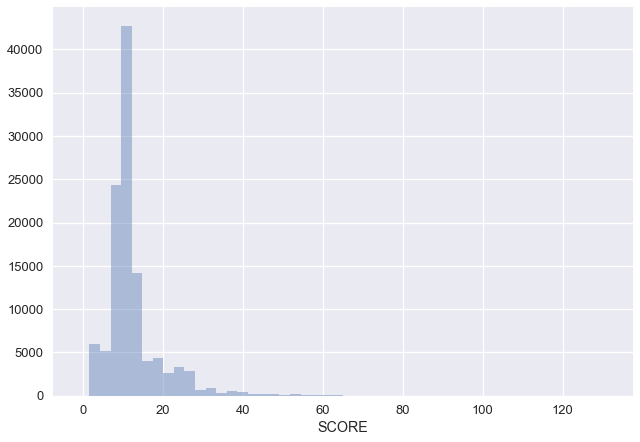

In [72]:
sns.set_context("talk")
score = dfex_viol['SCORE']
sns.distplot(score, kde = False)

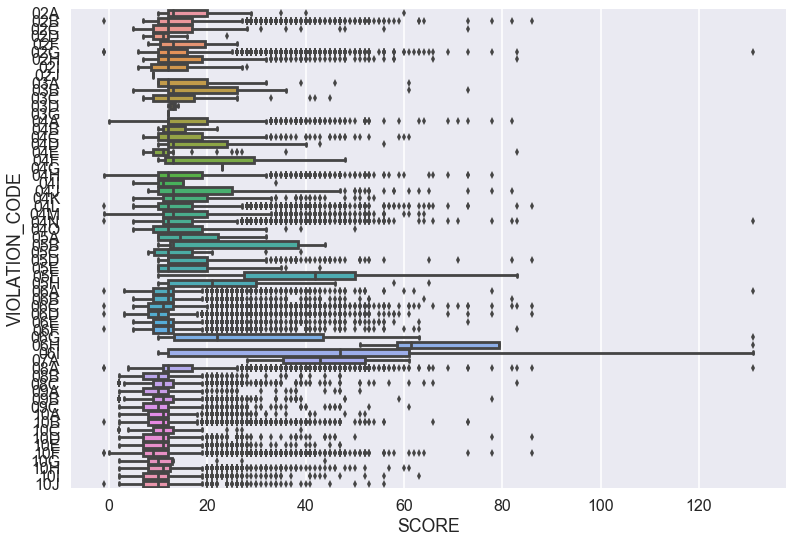

In [30]:
sns.set_context("poster")

data1=dfex_viol.sort_values(['VIOLATION_CODE'][-1])

yaxes = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['VIOLATION_CODE']
xaxes = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['SCORE']
sns.boxplot(x=xaxes, y=yaxes, data=data1)

In [18]:
sns.set_context("poster")

data1=dfex_viol.sort_values(['VIOLATION_CODE'][-1])

yaxes = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['VIOLATION_CODE']
xaxes = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['SCORE']
sns.boxplot(x=xaxes, y=yaxes, data=data1, ax = (16, 30))

AttributeError: 'tuple' object has no attribute 'boxplot'

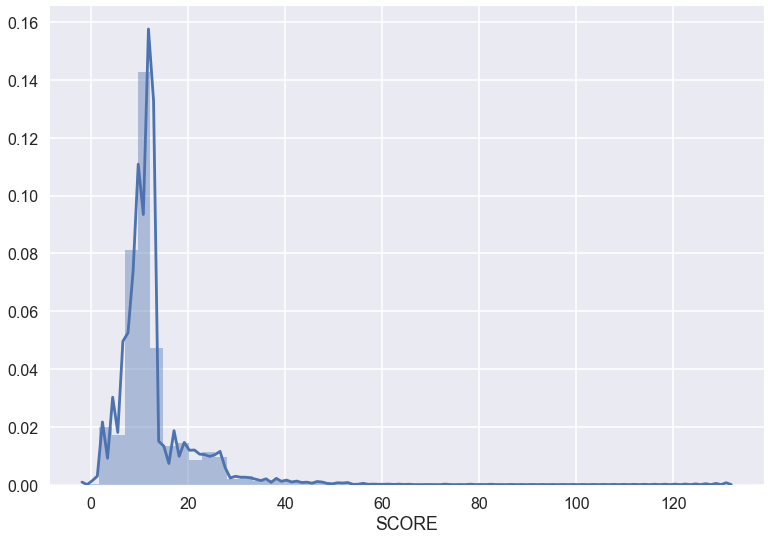

In [35]:

score = dfex_viol['SCORE']
sns.distplot(score)

In [19]:
data1=dfex_viol.sort_values(['VIOLATION_CODE'][-1])
y = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['VIOLATION_CODE']



# Start data observation

Testing and cleaning code

df_stats = creating a smaller DataFrame to run regressions/plot

In [ ]:
df_stats = df_clean.drop(['CAMIS', 
                          'PHONE',
                          'BORO', 
                          'BUILDING', 
                          'STREET', 
                          'ZIPCODE', 
                          'ACTION', 
                          'VIOLATION_CODE', 
                          'VIOLATION_DESC', 
                          'INSPECTION_TYPE', 
                          'URL'
                         ], 1)


Prep variables and defining functions to create Dummy Variables 'GRADE_NUM' and 'CRIT_FLAG_NUM'

In [ ]:
df_stats = df_stats[df_stats.GRADE != 'Z']
df_stats = df_stats[df_stats.GRADE != 'P']
df_stats = df_stats[df_stats.GRADE != 'Not Yet Graded']

In [ ]:
def grader(row):
    grade = row['GRADE']
    if grade=='A':
        return 0
    elif grade=='B':
        return 5
    elif grade=='C':
        return 10
    
df_stats['GRADE_NUM'] = df_stats.apply(grader, axis=1)

In [ ]:
def criticalflag(row):
    flag = row['CRITICAL_FLAG']
    if flag == 'Critical':
        return 1
    elif flag == 'Not Critical':
        return 0

df_stats['CRIT_FLAG_NUM'] = df_stats.apply(criticalflag, axis=1)

Drop remaining unneeded columns

In [ ]:
df_stats1=df_stats.drop(['DBA',
                        'CUISINE_DESC',
                        'INSPECTION_DATE',
                        'CRITICAL_FLAG',
                        'GRADE',
                        'GRADE_DATE',
                        'RECORD_DATE',
                        'ADDRESS',
                       ], 1)

In [ ]:
sns.pairplot(df_stats1[['SCORE', 'GRADE_NUM', 'CRIT_FLAG_NUM']], 
                       kind="scatter",
                       diag_kind="hist"
                       )


In [ ]:
score = df_stats['SCORE']
plt.hist(score)

In [ ]:
grade_num = df_stats1['GRADE_NUM']
plt.hist(grade_num)

In [ ]:
crit_flag_num = df_stats1['CRIT_FLAG_NUM']
plt.hist(crit_flag_num)

# Start Data Observation w/ Yelp data

df_yelp = Read in Yelp data as a DataFrame, and add a 'RATINGS' column that just has the rating number

In [6]:
yelp = '/Users/allandong/ds/metis/metisgh/Project-two-Luther/yelp.csv'

df_yelp= pd.read_csv(yelp)

yelp_cols = ['URL', 'YELP_RATINGS']
df_yelp.columns = yelp_cols

df_yelp = df_yelp[df_yelp['YELP_RATINGS'] != 'yelp_ratings']

def get_num(row):
    return float(row['YELP_RATINGS'].split()[0])

df_yelp['RATINGS'] = df_yelp.apply(get_num, axis=1)


In [7]:
def grader(row):
    grade = row['GRADE']
    if grade=='A':
        return 0
    elif grade=='B':
        return 5
    elif grade=='C':
        return 10

def criticalflag(row):
    flag = row['CRITICAL_FLAG']
    if flag == 'Critical':
        return 1
    elif flag == 'Not Critical':
        return 0

df_short = Remove extraneous columns from df_clean before concat

In [8]:
df_short = df_clean.drop(['CAMIS', 
                          'DBA',
                          'BORO', 
                          'BUILDING', 
                          'STREET', 
                          'PHONE',
                          'INSPECTION_DATE',
                          'ACTION',
                          'VIOLATION_DESC',
                          'GRADE_DATE',
                          'RECORD_DATE',
                          'INSPECTION_TYPE',
                          'ADDRESS',
                         ], 1)


df_ex = Concating df_short and df_yelp and with NaN's dropped

In [9]:
df_ex_pre= pd.merge(df_short, df_yelp, how='left',on='URL')

df_ex_pre = df_ex_pre.drop_duplicates().dropna(axis=0, how='any')

Create 'GRADE_NUM' and 'CRIT_FLAG_NUM' dummy variables from 'GRADE' and 'CRITICAL_FLAG' 


  'GRADE_NUM' = {'A':0, 'B':5, 'C':10}
  
  'CRIT_FLAG_NUM = {'Critical':1, 'Not Critical':0}

Remove extraneous columns and reindex columns

Create dummy variables from 'GRADE' and 'CRITICAL_FLAG' 

Remove extraneous columns and reindex columns

In [10]:

df_ex = df_ex_pre[df_ex_pre['GRADE'] != 'Z']
df_ex = df_ex[df_ex['GRADE'] != 'P']
df_ex = df_ex[df_ex['GRADE'] != 'Not Yet Graded']



dfex_cols = ['RATINGS', 'SCORE', 'CRITICAL_FLAG', 'GRADE', 'VIOLATION_CODE']
dfex = df_ex[dfex_cols]



In [11]:
dfex_cols_viol = ['RATINGS', 'SCORE', 'CRITICAL_FLAG', 'GRADE', 'VIOLATION_CODE']
dfex_viol_pre = df_ex[dfex_cols_viol]


df_ex_prex = df_ex.drop(['ZIPCODE', 'CUISINE_DESC', 'URL', 'YELP_RATINGS'],
           axis = 1)



In [12]:
critical_flag_patsy = patsy.dmatrix('CRITICAL_FLAG', data=dfex, return_type='dataframe').drop('Intercept', 1)
grade_num_patsy = patsy.dmatrix('GRADE', data=dfex, return_type='dataframe').drop('Intercept', 1)
violation_code_patsy = patsy.dmatrix('VIOLATION_CODE', data=dfex, return_type="dataframe").drop('Intercept', 1)



In [13]:
dfex_patsy = pd.concat([dfex, grade_num_patsy, critical_flag_patsy, violation_code_patsy], 
                      axis = 1, join_axes = [dfex.index])




dfex = dfex_viol_pre.drop(['GRADE', 'CRITICAL_FLAG', 'VIOLATION_CODE'], 1)
dfex_viol = dfex_viol_pre.drop(['GRADE', 'CRITICAL_FLAG'], 1)


In [14]:
df_exx = df_ex_prex


#cuisine_desc = pd.get_dummies(df_exx['CUISINE_DESC'])
#critical_flag = pd.get_dummies(df_exx['CRITICAL_FLAG'])
#grade_num = pd.get_dummies(df_exx['GRADE'])




In [17]:
critical_flag_patsy = patsy.dmatrix('CRITICAL_FLAG', data=df_exx, return_type='dataframe').drop('Intercept', 1)
grade_num_patsy = patsy.dmatrix('GRADE', data=df_exx, return_type='dataframe').drop('Intercept', 1)
violation_code_patsy = patsy.dmatrix('VIOLATION_CODE', data=df_exx, return_type="dataframe").drop('Intercept', 1)

#df_exx = pd.concat([df_exx, grade_num, critical_flag], axis = 1, join_axes = [df_exx.index])
df_exx = pd.concat([df_exx, 
                    grade_num_patsy, 
                    critical_flag_patsy, 
                    violation_code_patsy
                   ], axis = 1, join_axes = [df_exx.index])

df_exx = df_exx.drop(['VIOLATION_CODE', 'CRITICAL_FLAG', 'GRADE'],
           axis = 1)




PatsyError: Error evaluating factor: NameError: name 'CRITICAL_FLAG' is not defined
    CRITICAL_FLAG
    ^^^^^^^^^^^^^

In [18]:
dfex_patsy.head()

,RATINGS,SCORE,CRITICAL_FLAG,GRADE,VIOLATION_CODE,GRADE[T.B],GRADE[T.C],CRITICAL_FLAG[T.Not Critical],VIOLATION_CODE[T.02B],VIOLATION_CODE[T.02C],...,VIOLATION_CODE[T.10A],VIOLATION_CODE[T.10B],VIOLATION_CODE[T.10C],VIOLATION_CODE[T.10D],VIOLATION_CODE[T.10E],VIOLATION_CODE[T.10F],VIOLATION_CODE[T.10G],VIOLATION_CODE[T.10H],VIOLATION_CODE[T.10I],VIOLATION_CODE[T.10J]
0,2.5,27.0,Critical,B,02B,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,3.5,9.0,Critical,A,02B,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67,4.0,12.0,Critical,A,06D,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,4.0,7.0,Not Critical,A,10F,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
106,4.0,7.0,Critical,A,06F,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Check each column for non numeric values

Examine data and preliminary analysis of R2

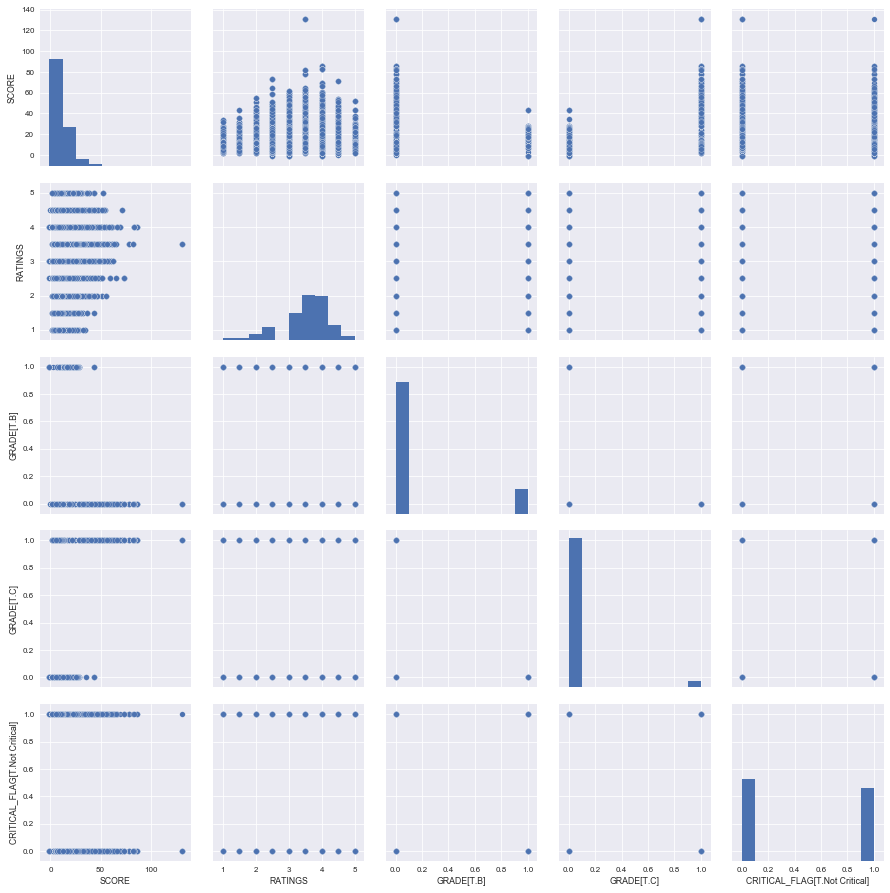

In [22]:
sns.set_context("paper")
sns.pairplot(dfex_patsy[['SCORE','RATINGS', 'GRADE[T.B]', 'GRADE[T.C]',
       'CRITICAL_FLAG[T.Not Critical]']], kind="scatter", diag_kind="hist")


In [23]:
dfex.corr()

,RATINGS,SCORE
RATINGS,1.000000,-0.028029
SCORE,-0.028029,1.000000


In [24]:
y, X = patsy.dmatrices('RATINGS ~ SCORE + RATINGS + GRADE[T.B] + GRADE[T.C] + CRITICAL_FLAG[T.Not Critical]', data=dfex, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()


#lml = smf.ols('Y ')

SyntaxError: invalid syntax (<unknown>, line 1)

Check R2 with LinearRegression


Legend:

dfex : [y = 'RATINGS', x = 'SCORE', 'GRADE_NUM', 'CRIT_FLAG_NUM']

dfex1 : [y = 'SCORE', x ='RATINGS', 'GRADE_NUM', 'CRIT_FLAG_NUM']

dfex2 : [y = 'SCORE', x ='RATINGS', 'CRIT_FLAG_NUM']

dfex1_viol : [y = 'SCORE', x = 'RATINGS', 'GRADE_NUM', 'CRIT_FLAG_NUM', VIOLATION_CODE-dummies]

dfex2_viol : [y = 'SCORE', x = 'RATINGS', 'CRIT_FLAG_NUM', VIOLATION_CODE-dummies]

In [ ]:

dfex1_cols = ['SCORE', 'RATINGS', 'GRADE[T.B]', 'GRADE[T.C]', 'CRITICAL_FLAG[T.Not Critical]']
dfex1= dfex_patsy[dfex1_cols]


dfex1_viol = dfex_patsy

In [ ]:
dfex2 = dfex1.drop(['GRADE[T.B]', 'GRADE[T.C]'], 1)
dfex2_viol = dfex1_viol.drop(['GRADE[T.B]', 'GRADE[T.C]'], 1)


In [ ]:
lr = LinearRegression()
X = dfex1.iloc[:, 1:]
y = dfex1.iloc[:, 0]

lr.fit(X, y)
lr.score(X,y)

In [ ]:
lr = LinearRegression(fit_intercept = True)





X = dfex2.iloc[:, 1:]
y = dfex2.SCORE
lr.fit(X,y)
lr.score(X,y)
#print('X: ', list(X))
#print(dfex2.columns)

In [ ]:
dfex2.columns

In [ ]:

X = dfex1_viol.iloc[:, 1:]
y = dfex1_viol.iloc[:, 0]

lr.fit(X, y)
lr.score(X,y)

In [ ]:
X = dfex2_viol.iloc[:, 1:]
y = dfex2_viol.iloc[:, 0]

lr.fit(X,y)
lr.score(X,y)

In [ ]:
dfex2_viol_cols = ''
for i in dfex2_viol.columns:
    dfex2_viol_cols += i + "+"
dfex2_viol_patsy_str = 'SCORE ~ '+ dfex2_viol_cols[6:-1]
dfex2_viol_patsy_str


In [25]:
dfex_patsy.columns

Index(['RATINGS', 'SCORE', 'CRITICAL_FLAG', 'GRADE', 'VIOLATION_CODE',
       'GRADE[T.B]', 'GRADE[T.C]', 'CRITICAL_FLAG[T.Not Critical]',
       'VIOLATION_CODE[T.02B]', 'VIOLATION_CODE[T.02C]',
       'VIOLATION_CODE[T.02D]', 'VIOLATION_CODE[T.02F]',
       'VIOLATION_CODE[T.02G]', 'VIOLATION_CODE[T.02H]',
       'VIOLATION_CODE[T.02I]', 'VIOLATION_CODE[T.02J]',
       'VIOLATION_CODE[T.03A]', 'VIOLATION_CODE[T.03B]',
       'VIOLATION_CODE[T.03C]', 'VIOLATION_CODE[T.03D]',
       'VIOLATION_CODE[T.03G]', 'VIOLATION_CODE[T.04A]',
       'VIOLATION_CODE[T.04B]', 'VIOLATION_CODE[T.04C]',
       'VIOLATION_CODE[T.04D]', 'VIOLATION_CODE[T.04E]',
       'VIOLATION_CODE[T.04F]', 'VIOLATION_CODE[T.04G]',
       'VIOLATION_CODE[T.04H]', 'VIOLATION_CODE[T.04I]',
       'VIOLATION_CODE[T.04J]', 'VIOLATION_CODE[T.04K]',
       'VIOLATION_CODE[T.04L]', 'VIOLATION_CODE[T.04M]',
       'VIOLATION_CODE[T.04N]', 'VIOLATION_CODE[T.04O]',
       'VIOLATION_CODE[T.05A]', 'VIOLATION_CODE[T.05B]',
      

In [26]:
dfex_patsy1 = dfex_patsy.drop(['GRADE', 'VIOLATION_CODE', 'CRITICAL_FLAG'],1 )

y_dfex2 = dfex_patsy1.SCORE
X_dfex2 = dfex_patsy1.drop(['SCORE'], 1)

model_dfex2 = sm.OLS(y_dfex2, X_dfex2)
fit_dfex2 =model_dfex2.fit()
fit_dfex2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SCORE   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 2.364e+04
Date:                Sat, 15 Jul 2017   Prob (F-statistic):               0.00
Time:                        21:12:19   Log-Likelihood:            -3.1379e+05
No. Observations:              113506   AIC:                         6.277e+05
Df Residuals:                  113442   BIC:                         6.283e+05
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
RATINGS                           0.0910      0.015      5.932      0.000       0.061       0.121
GRADE[T.B]                       10.1518      0.032    313.304      0.000      10.088      10.215
GRADE[T.C]                       25.8531      0.059    440.556      0.000      25.738      25.968
CRITICAL_FLAG[T.Not Critical]     8.6000      0.084    101.918      0.000       8.435       8.765
VIOLATION_CODE[T.02B]            10.3505      0.077    133.996      0.000      10.199      10.502
VIOLATION_CODE[T.02C]             9.7464      0.307     31.710      0.000       9.144      10.349
VIOLATION_CODE[T.02D]             9.4508      1.282      7.375      0.000       6.939      11.963
VIOLATION_CODE[T.02F]            11.9491      2.219      5.386      0.000       7.600      16.298
VIOLATION_CODE[T.02G]            10.3361      0.070    147.456      0.000      10.199      10.473
VIOLATION_CODE[T.02H]            10.4093      0.129     80.798      0.000      10.157      10.662
VIOLATION_CODE[T.02I]            10.2944      0.617     16.672      0.000       9.084      11.505
VIOLATION_CODE[T.02J]             8.7270      3.842      2.272      0.023       1.197      16.257
VIOLATION_CODE[T.03A]            11.2724      0.388     29.038      0.000      10.512      12.033
VIOLATION_CODE[T.03B]            12.0989      0.595     20.325      0.000      10.932      13.266
VIOLATION_CODE[T.03C]            10.3045      0.610     16.901      0.000       9.109      11.499
VIOLATION_CODE[T.03D]             9.2824      2.219      4.184      0.000       4.934      13.631
VIOLATION_CODE[T.03G]            11.6360      3.842      3.029      0.002       4.105      19.167
VIOLATION_CODE[T.04A]            10.9296      0.109    100.713      0.000      10.717      11.142
VIOLATION_CODE[T.04B]            10.6836      1.453      7.354      0.000       7.836      13.531
VIOLATION_CODE[T.04C]            10.2123      0.145     70.579      0.000       9.929      10.496
VIOLATION_CODE[T.04D]            11.1097      0.411     27.050      0.000      10.305      11.915
VIOLATION_CODE[T.04E]            10.5445      0.400     26.362      0.000       9.761      11.328
VIOLATION_CODE[T.04F]            14.1520      1.453      9.739      0.000      11.304      17.000
VIOLATION_CODE[T.04G]            12.4842      3.842      3.249      0.001       4.953      20.015
VIOLATION_CODE[T.04H]            10.3309      0.100    103.709      0.000      10.136      10.526
VIOLATION_CODE[T.04I]             7.5078      1.719      4.368      0.000       4.139      10.877
VIOLATION_CODE[T.04J]            11.4194      0.179     63.707      0.000      11.068      11.771
VIOLATION_CODE[T.04K]            10.0483      0.163     61.555      0.000       9.728      10.368
VIOLATION_CODE[T.04L]            10.2320     

In [118]:
critical_flag_patsy = patsy.dmatrix('CRITICAL_FLAG', data=df_ex, return_type='dataframe').drop('Intercept', 1)
grade_num_patsy = patsy.dmatrix('GRADE', data=df_ex, return_type='dataframe').drop('Intercept', 1)
violation_code_patsy = patsy.dmatrix('VIOLATION_CODE', data=df_ex, return_type="dataframe").drop('Intercept', 1)
zipcode_patsy = patsy.dmatrix('ZIPCODE', data=df_ex, return_type="dataframe").drop('Intercept', 1)

df_dummy_cgvz = pd.concat([df_ex, 
#                      grade_num_patsy, 
#                      critical_flag_patsy, 
#                      violation_code_patsy,
                      zipcode_patsy
                   ], axis = 1, join_axes = [df_exx.index])

df_dummy_cgvz = df_dummy_cgvz.drop(['VIOLATION_CODE', 
                                    'CRITICAL_FLAG', 
                                    'GRADE', 
                                    'ZIPCODE', 
                                    'CUISINE_DESC',
                                    'URL',
                                    'YELP_RATINGS'
                                   ],axis = 1)

df_dummy_cgvz.columns


Index(['SCORE', 'RATINGS'], dtype='object')

In [145]:



master = dfex2
#df_dummy_cgvz
y = master.SCORE
X= master.drop(['SCORE'], 1)

print(X.columns)

model_dfex2 = sm.OLS(y, X)
fit_dfex2 =model_dfex2.fit()
fit_dfex2.summary()


Index(['RATINGS', 'CRITICAL_FLAG[T.Not Critical]'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SCORE   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                 1.382e+05
Date:                Fri, 14 Jul 2017   Prob (F-statistic):               0.00
Time:                        12:37:47   Log-Likelihood:            -3.9487e+05
No. Observations:              113506   AIC:                         7.898e+05
Df Residuals:                  113504   BIC:                         7.898e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
RATINGS                           3.6069      0.009    411.878      0.000       3.590       3.624
CRITICAL_FLAG[T.Not Critical]    -1.4972      0.046    -32.771      0.000      -1.587      -1.408
==============================================================================
Omnibus:                    61778.657   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           744953.250
Skew:                           2.376   Prob(JB):                         0.00
Kurtosis:                      14.616   Cond. No.                         7.14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
df_ex.columns

Index(['ZIPCODE', 'CUISINE_DESC', 'VIOLATION_CODE', 'CRITICAL_FLAG', 'SCORE',
       'GRADE', 'URL', 'YELP_RATINGS', 'RATINGS'],
      dtype='object')

In [178]:
lr = LinearRegression()

df_exx_lr= df_exx.drop(['GRADE[T.B]', 'GRADE[T.C]'], 1)
X = df_exx_lr.drop(['RATINGS'], 1)
y = df_exx_lr.RATINGS

lr.fit(X, y)
lr.score(X, y)

0.0042403666226124015

In [179]:
df_exx_lr.columns

Index(['SCORE', 'RATINGS', 'CRITICAL_FLAG[T.Not Critical]',
       'VIOLATION_CODE[T.02B]', 'VIOLATION_CODE[T.02C]',
       'VIOLATION_CODE[T.02D]', 'VIOLATION_CODE[T.02F]',
       'VIOLATION_CODE[T.02G]', 'VIOLATION_CODE[T.02H]',
       'VIOLATION_CODE[T.02I]', 'VIOLATION_CODE[T.02J]',
       'VIOLATION_CODE[T.03A]', 'VIOLATION_CODE[T.03B]',
       'VIOLATION_CODE[T.03C]', 'VIOLATION_CODE[T.03D]',
       'VIOLATION_CODE[T.03G]', 'VIOLATION_CODE[T.04A]',
       'VIOLATION_CODE[T.04B]', 'VIOLATION_CODE[T.04C]',
       'VIOLATION_CODE[T.04D]', 'VIOLATION_CODE[T.04E]',
       'VIOLATION_CODE[T.04F]', 'VIOLATION_CODE[T.04G]',
       'VIOLATION_CODE[T.04H]', 'VIOLATION_CODE[T.04I]',
       'VIOLATION_CODE[T.04J]', 'VIOLATION_CODE[T.04K]',
       'VIOLATION_CODE[T.04L]', 'VIOLATION_CODE[T.04M]',
       'VIOLATION_CODE[T.04N]', 'VIOLATION_CODE[T.04O]',
       'VIOLATION_CODE[T.05A]', 'VIOLATION_CODE[T.05B]',
       'VIOLATION_CODE[T.05C]', 'VIOLATION_CODE[T.05D]',
       'VIOLATION_CODE[T.05E

In [ ]:
reg = LinearRegression()
X = df_exx.iloc[:, 1:]
y = df_exx.iloc[:, 0]
scores = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

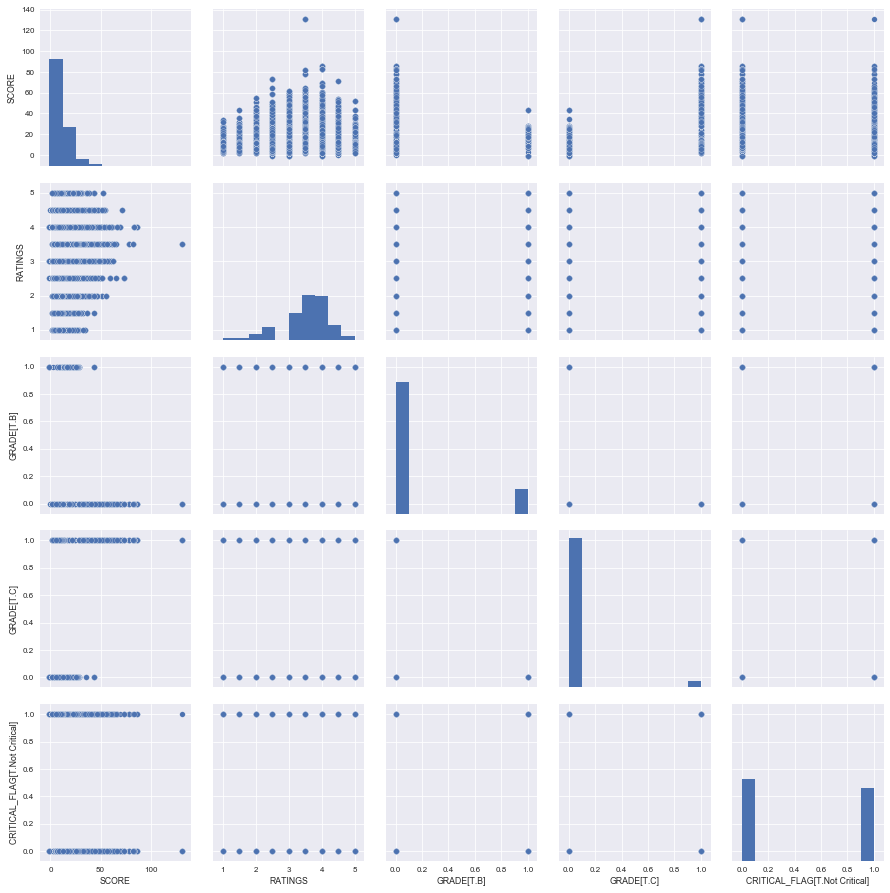

In [54]:
sns.pairplot(dfex_patsy[['SCORE', 'RATINGS','GRADE[T.B]','GRADE[T.C]','CRITICAL_FLAG[T.Not Critical]']], 
                       kind="scatter",
                       diag_kind="hist"
                       )


In [ ]:
df

In [ ]:
dfex2_viol_cols = ''
for i in dfex2_viol.columns:
    dfex2_viol_cols += i + "+"
dfex2_viol_patsy_str = 'SCORE ~ '+ dfex2_viol_cols[6:-1]
dfex2_viol_patsy_str

In [ ]:
'''y, X = patsy.dmatrices(dfex2_viol_patsy_str,
                       data=dfex2_viol, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()
'''

In [ ]:
'''df_exx_cols = ''
for i in df_exx.columns:
    df_exx_cols += i + " + "
df_exx_cols = "SCORE ~ " + df_exx_cols[8:-3] 
df_exx_cols'''

In [ ]:
'''y_df_exx, X_df_exxx = patsy.dmatrices(df_exx_cols, data=df_exx, return_type="dataframe")
model_df_exx = sm.OLS(y_df_exx, X_df_exx)
fit_df_exx = model_df_exx.fit()
fit_df_exx.summary()'''

# Violation Code

In [14]:
df_viol = df_clean.drop(['CAMIS', 
                          'DBA',
                          'BORO', 
                          'BUILDING', 
                          'STREET', 
                          'ZIPCODE',
                          'PHONE',
                          'CUISINE_DESC',
                          'INSPECTION_DATE',
                          'ACTION',
                          'SCORE',
                          'GRADE',
                          'GRADE_DATE',
                          'RECORD_DATE',
                          'INSPECTION_TYPE',
                          'ADDRESS',
                          'URL'
                         ], 1)
df_viol = df_viol.drop_duplicates(subset='VIOLATION_CODE')
df_viol =df_viol.sort_values(['VIOLATION_CODE'])
df_viol.head(60)

,VIOLATION_CODE,VIOLATION_DESC,CRITICAL_FLAG
1769,02A,Food not cooked to required minimum temperature.,Critical
2,02B,Hot food item not held at or above 140Âº F.,Critical
1254,02C,Hot food item that has been cooked and refrige...,Critical
11639,02D,Precooked potentially hazardous food from comm...,Critical
39805,02F,"Meat, fish or molluscan shellfish served raw o...",Critical
15,02G,Cold food item held above 41Âº F (smoked fish ...,Critical
502,02H,Food not cooled by an approved method whereby ...,Critical
10102,02I,Food prepared from ingredients at ambient temp...,Critical
254753,02J,Reduced oxygen packaged (ROP) foods not cooled...,Critical
916,03A,Food from unapproved or unknown source or home...,Critical


In [23]:
df_04k = df_clean[df_clean.VIOLATION_CODE=='04K']
df_04l = df_clean[df_clean.VIOLATION_CODE=='04L']
df_04m = df_clean[df_clean.VIOLATION_CODE=='04M']
df_04n = df_clean[df_clean.VIOLATION_CODE=='04N']

df_04 = pd.concat


,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESC,INSPECTION_DATE,ACTION,VIOLATION_CODE,VIOLATION_DESC,CRITICAL_FLAG,SCORE,GRADE,GRADE_DATE,RECORD_DATE,INSPECTION_TYPE,ADDRESS,URL
124,41030858,LA MIA PIZZA,MANHATTAN,1488,1 AVENUE,10075.0,2124721200,Pizza,10/15/2015,Violations were cited in the following area(s).,04K,Evidence of rats or live rats present in facil...,Critical,25.0,B,10/15/2015,07/09/2017,Cycle Inspection / Re-inspection,1488 1 AVENUE MANHATTAN,https://www.yelp.com/search?find_desc=LA+MIA+P...
248,50017475,EL PARROQUENO RESTAURANT,QUEENS,10203A,44TH AVENUE,11368.0,7185650348,"Latin (Cuban, Dominican, Puerto Rican, South &...",06/22/2017,Violations were cited in the following area(s).,04K,Evidence of rats or live rats present in facil...,Critical,26.0,Z,06/22/2017,07/09/2017,Cycle Inspection / Re-inspection,10203A 44TH AVENUE QUEENS,https://www.yelp.com/search?find_desc=EL+PARRO...
364,50035649,CROWN FRIED CHICKEN,BROOKLYN,577,SUTTER AVE,11207.0,3474058729,Chicken,06/07/2017,Violations were cited in the following area(s).,04K,Evidence of rats or live rats present in facil...,Critical,12.0,A,06/07/2017,07/09/2017,Cycle Inspection / Re-inspection,577 SUTTER AVE BROOKLYN,https://www.yelp.com/search?find_desc=CROWN+FR...
488,50053879,LA CUEVITA DE MACHO,BRONX,260,BROOK AVE,10454.0,6462917858,Spanish,02/03/2017,Violations were cited in the following area(s).,04K,Evidence of rats or live rats present in facil...,Critical,11.0,A,02/03/2017,07/09/2017,Pre-permit (Operational) / Re-inspection,260 BROOK AVE BRONX,https://www.yelp.com/search?find_desc=LA+CUEVI...
513,41441357,FEI HUANG BAKERY,BROOKLYN,6321,20 AVENUE,11204.0,7182322268,Bakery,09/16/2015,Violations were cited in the following area(s).,04K,Evidence of rats or live rats present in facil...,Critical,13.0,A,09/16/2015,07/09/2017,Cycle Inspection / Re-inspection,6321 20 AVENUE BROOKLYN,https://www.yelp.com/search?find_desc=FEI+HUAN...
573,50050004,EAT FRESH II,BROOKLYN,42,4TH AVE,11217.0,7188557866,Mediterranean,10/18/2016,Violations were cited in the following area(s).,04K,Evidence of rats or live rats present in facil...,Critical,13.0,A,10/18/2016,07/09/2017,Pre-permit (Operational) / Re-inspection,42 4TH AVE BROOKLYN,https://www.yelp.com/search?find_desc=EAT+FRES...
859,50007162,TINA RESTAURANT,BRONX,2350,WASHINGTON AVE,10458.0,3475907591,American,04/23/2015,Violations were cited in the following area(s).,04K,Evidence of rats or live rats present in facil...,Critical,10.0,A,04/23/2015,07/09/2017,Cycle Inspection / Re-inspection,2350 WASHINGTON AVE BRONX,https://www.yelp.com/search?find_desc=TINA++RE...
1022,41642872,ORIENTAL HOUSE,BRONX,565,E 184TH ST,10458.0,7185638888,Chinese,09/28/2015,Violations were cited in the following area(s).,04K,Evidence of rats or live rats present in facil...,Critical,10.0,A,09/28/2015,07/09/2017,Cycle Inspection / Re-inspection,565 E 184TH ST BRONX,https://www.yelp.com/search?find_desc=ORIENTAL...
1896,41512126,LP 'N HARMONY,BROOKLYN,683,GRAND STREET,11211.0,6467658269,American,04/10/2013,Violations were cited in the following area(s).,04K,Evidence of rats or live rats present in facil...,Critical,13.0,A,04/10/2013,07/09/2017,Cycle Inspection / Initial Inspection,683 GRAND STREET BROOKLYN,https://www.yelp.com/search?find_desc=LP+'N+HA...
2077,41529719,WING HUA II,BROOKLYN,223,CHURCH AVENUE,11218.0,7184368833,Chinese,12/31/2014,Violations were cited in the following area(s).,04K,Evidence of rats or live rats present in facil...,Critical,11.0,A,12/31/2014,07/09/2017,Cycle Inspection / Re-inspection,223 CHURCH AVENUE BROOKLYN,https://www.yelp.com/search?find_desc=WING+HUA...


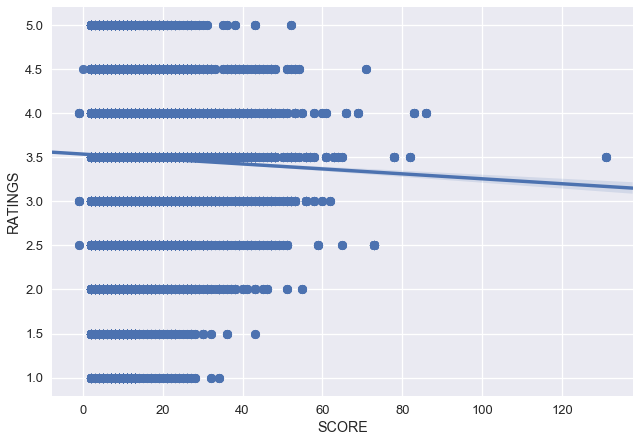

In [163]:
x =df_ex.SCORE
y = df_ex.RATINGS

sns.regplot(x, y)

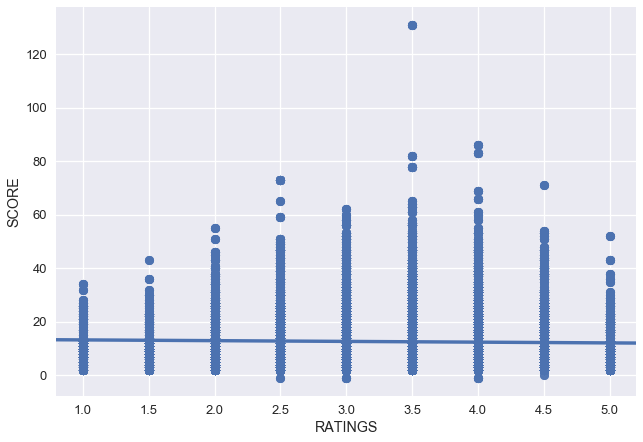

In [161]:
sns.regplot(y, x)

In [180]:
x =df_ex.SCORE
y = df_ex.RATINGS.apply(,1)

sns.regplot(x, y)

NameError: name 'log' is not defined